In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, distributions
from torch.nn import functional as F
from torch import distributions as D
from torchvision.datasets import MNIST, FashionMNIST
from torchvision import transforms
!pip install pytorch-lightning wandb -q
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torch.distributions import Normal, Laplace, kl_divergence, kl, Categorical
import math
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
!mkdir data

     |████████████████████████████████| 696kB 6.0MB/s 
     |████████████████████████████████| 2.0MB 10.8MB/s 
     |████████████████████████████████| 102kB 12.6MB/s 
     |████████████████████████████████| 276kB 27.1MB/s 
     |████████████████████████████████| 829kB 32.6MB/s 
     |████████████████████████████████| 133kB 54.6MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 163kB 36.5MB/s 
     |████████████████████████████████| 1.3MB 37.7MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 143kB 55.8MB/s 
     |████████████████████████████████| 296kB 58.4MB/s 


In [2]:
!nvidia-smi

Fri Feb 12 14:22:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from time import time
from contextlib import contextmanager

@contextmanager
def timethis(label):
    t0 = time()
    yield
    elapsed = time() - t0
    print(f"{label} took {elapsed} seconds")

In [4]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: torch.flatten(x))])

def get_autoencoder(n_neurons, batch_norm=True):
    enc_layers = len(n_neurons)
    layer_dims = n_neurons + n_neurons[-2::-1]
    n_layers = len(layer_dims)
    return nn.Sequential(*[nn.Sequential(nn.Linear(layer_dims[i], layer_dims[i+1]),
                                         nn.Identity() \
                                            if i+2 == enc_layers or i+2 == n_layers or not batch_norm \
                                            else nn.BatchNorm1d(layer_dims[i+1]),
                                         nn.Identity() \
                                            if i+2 == enc_layers or i+2 == n_layers \
                                            else nn.ELU()) \
                           for i in range(n_layers - 1)])

def get_encoder_decoder(n_neurons, batch_norm=True):
    n_layers = len(n_neurons) - 1
    encoder_layers = [nn.Sequential(nn.Linear(n_neurons[i], n_neurons[i+1]),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(n_neurons[i+1]) if batch_norm else nn.Identity()) for i in range(n_layers - 1)]
    encoder_layers.append(nn.Linear(n_neurons[-2], n_neurons[-1]))
    n_neurons = n_neurons[::-1]
    decoder_layers = [nn.Sequential(nn.Linear(n_neurons[i], n_neurons[i+1]),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(n_neurons[i+1]) if batch_norm else nn.Identity()) for i in range(n_layers - 1)]
    decoder_layers.append(nn.Sequential(nn.Linear(n_neurons[-2], n_neurons[-1]), nn.Sigmoid()))
    return nn.Sequential(*encoder_layers), nn.Sequential(*decoder_layers)

class SimpleAutoencoder(pl.LightningModule):
    def __init__(self, n_neurons=[784, 512, 256, 10], lr=1e-3, batch_norm=True):
        super(SimpleAutoencoder, self).__init__()
        self.hparams = {'lr': lr}
        self.encoder, self.decoder = get_encoder_decoder(n_neurons, batch_norm)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), self.hparams['lr'])
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2 ,patience=20, verbose=True, min_lr=1e-6)
        scheduler = {'scheduler': sched, 'interval': 'epoch', 'monitor': 'val_checkpoint_on', 'reduce_on_plateau': True}
        return opt

    def shared_step(self, batch, batch_idx):
        bx, by = batch
        z = self.encoder(bx)
        out = self.decoder(z)
        loss = F.mse_loss(out, bx)
        bce_loss = F.binary_cross_entropy(torch.clamp(out, 1e-6, 1 - 1e-6), bx, reduction='mean')
        self.log('loss', loss)
        self.log('bce_loss', bce_loss)
        lmbda = 0.00
        reg = lmbda * (z**2).mean()
        self.log('regularization', reg)
        return bce_loss
    
    def training_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx)

    def validation_step(self, batch, batch_idx):
        return self.shared_step(batch, batch_idx)

    def train_dataloader(self):
        dataset = MNIST("data", download=True, transform=transform)
        return DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

    def val_dataloader(self):
        dataset = MNIST("data", download=True, transform=transform, train=False)
        return DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

    def encode(self, batch):
        bx, by = batch
        return self.encoder(bx)

    def encode_ds(self, ds):
        dl = DataLoader(ds, batch_size=256, num_workers=4, shuffle=False)
        self.eval()
        encoded = []
        with torch.no_grad():
            for batch in dl:
                encoded.append(self.encode(batch).detach().cpu().numpy())
        return np.concatenate(encoded, axis=0)

    def cluster(self, ds, k=10):
        X = self.encode_ds(ds)
        kmeans = KMeans(k)
        return kmeans.fit_predict(X)


In [ ]:
def normal_to_multivariate1(p):
    return D.LowRankMultivariateNormal(p.mean, torch.zeros_like(p.mean[:1].T), p.stddev)

def normal_to_multivariate2(p):
    return D.MultivariateNormal(p.mean, covariance_matrix=torch.diag_embed(p.variance))

def normal_to_multivariate3(p):
    return D.MultivariateNormal(p.mean, scale_tril=torch.diag_embed(p.stddev))


# @D.register_kl(D.Normal, D.MultivariateNormal)
# def kl_normal_multivariateNormal(p, q):
#     p_lrmv =D.LowRankMultivariateNormal(p.mean, torch.zeros_like(p.loc.T), p.stddev)
#     return kl_divergence(p_lrmv, q)

%timeit -n 100 normal_to_multivariate(dist)
%timeit -n 100 normal_to_multivariate2(dist)
%timeit -n 100 normal_to_multivariate3(dist)

100 loops, best of 3: 184 µs per loop
100 loops, best of 3: 124 µs per loop
100 loops, best of 3: 38.8 µs per loop


In [ ]:
dist = D.Independent(D.Normal(torch.randn(100, 5), torch.rand(100, 5) + 1), 1)
d1 = D.LowRankMultivariateNormal(dist.mean, torch.zeros_like(dist.mean.T), cov_diag=dist.stddev)
d2 = D.MultivariateNormal(d1.loc + 1, covariance_matrix=d1.covariance_matrix)
kl_divergence(d1, d2)

tensor([1.7981, 1.8643, 1.8574, 1.7771, 1.9044, 1.7160, 1.9418, 1.7388, 1.6433,
        1.6572, 1.8190, 1.9236, 1.5556, 1.8028, 1.9198, 1.7159, 1.7555, 1.7941,
        1.7712, 1.8146, 1.9566, 1.8463, 1.6950, 1.7007, 1.7570, 1.9324, 1.8007,
        1.3834, 1.4124, 1.6966, 1.5893, 1.7331, 1.8036, 1.6080, 1.6988, 1.5650,
        1.7721, 2.0393, 1.9991, 1.7298, 1.9784, 1.6029, 1.5733, 1.7367, 1.7062,
        1.8806, 1.8199, 1.6476, 1.8545, 1.8075, 1.7348, 1.7166, 1.6927, 1.7388,
        1.8278, 1.7464, 1.6123, 1.6893, 1.5510, 1.7665, 1.9022, 1.5869, 1.6793,
        2.0186, 1.5733, 1.6266, 1.8894, 1.7498, 1.8387, 1.5944, 1.6010, 1.6319,
        1.6464, 1.3098, 2.1298, 1.6669, 1.3988, 1.4148, 1.5838, 1.8465, 1.9432,
        1.8254, 1.8010, 1.8407, 1.6515, 1.6028, 1.7256, 1.7622, 1.7102, 1.8950,
        2.1240, 1.9696, 1.7765, 1.4353, 1.5961, 1.8621, 1.7754, 1.6057, 1.5714,
        2.0713])

In [5]:

def normal_to_multivariate(p):
    return D.MultivariateNormal(p.mean, scale_tril=torch.diag_embed(p.stddev))

def cross_entropy(P, Q):
    try:
        return kl_divergence(P, Q) + P.entropy()
    except NotImplementedError:
        if type(P) == D.Independent and type(P.base_dist) == D.Normal:
            return kl_divergence(normal_to_multivariate(P), Q) + P.entropy()
        raise NotImplementedError

def cross_entropy_estimate(P, Q, k=100):
    samples = P.sample((k,))
    return - Q.log_prob(samples).mean()

def cross_entropy_normal(P, Q):
    return 0.5 * torch.log(2 * math.pi * Q.scale**2) + 0.5 * (P.scale / Q.scale)**2 + 0.5 * ((P.loc - Q.loc)/Q.scale)**2 


class LatentDistribution(nn.Module):
    prior = Normal(0, 1)
    def __init__(self, in_features, out_features, sigma=None, same_sigma=False):
        super(LatentDistribution, self).__init__()
        # self.multivariate = multivariate
        self.mu_fc = nn.Linear(in_features, out_features)
        if sigma:
            self.sigma = sigma
        else:
            if same_sigma:
                self.logvar_fc = nn.Linear(in_features, 1)
                self.logvar_fc.weight.data.zero_()
                self.logvar_fc.bias.data.zero_()
            else:
                self.logvar_fc = nn.Linear(in_features, out_features)
                self.logvar_fc.weight.data.zero_()
                self.logvar_fc.bias.data.zero_()
                # self.logvar_fc.bias.data -= 10.
        
    
    def forward(self, x):
        mu = self.mu_fc(x)
        if hasattr(self, 'sigma'):
            sigma = self.sigma
        else:
            logvar = self.logvar_fc(x)
            sigma = torch.exp(logvar / 2)
        self.dist = D.Independent(Normal(mu, sigma), 1)
        return self.dist
    
    def sample(self, l=1):
        return self.dist.rsample()

    def kl_loss(self, prior=None):
        if not prior:
            prior = self.prior
        return kl_divergence(self.dist, prior).sum(dim=-1)

class BernoulliDistribution(nn.Module):
    def __init__(self, in_features, out_features):
        super(BernoulliDistribution, self).__init__()
        self.probs = nn.Sequential(nn.Linear(in_features, out_features), nn.Sigmoid())
    
    def forward(self, x):
        self.dist = D.Bernoulli(probs=self.probs(x))
        return self.dist

In [ ]:
np.ones((100, 3, 5)).transpose((0, 2, 1)).shape

(100, 5, 3)

In [6]:
from torch import autograd
from torch.utils.data import ConcatDataset, TensorDataset

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: torch.flatten(x))])

# def xlogx(x, eps=1e-12):
#     xlog = x * (x + eps).log()
#     # import pdb; pdb.set_trace()
#     return xlog

# def clustering_accuracy(gt, cluster_assignments):
#     mat = metrics.confusion_matrix(cluster_assignments, gt, labels=np.arange(max(max(gt), max(cluster_assignments)) + 1))
#     cluster_assignments = mat.argmax(axis=1)[cluster_assignments]
#     return metrics.accuracy_score(gt, cluster_assignments)

class VaDE(nn.Module):
    def __init__(self, n_neurons=[784, 512, 256, 10], batch_norm=True, k=10, lr=1e-3, device='cuda',
                 pretrain_model=None, init_gmm=None, logger=None, covariance_type=None, debug=True):
        super(VaDE, self).__init__()
        self.k = k
        self.log = logger
        self.n_neurons, self.batch_norm = n_neurons, batch_norm
        self.debug = debug
        self.hparams = {'lr': lr}
        self.hparams['covariance_type'] = covariance_type
        self.latent_dim = n_neurons[-1]
        self.mixture_logits = nn.Parameter(torch.zeros(k, device=device))
        self.mu_c = nn.Parameter(torch.zeros(k, self.latent_dim, device=device))
        if self.hparams['covariance_type'] == 'diag':
            self.sigma_c = nn.Parameter(torch.ones(k, self.latent_dim, device=device))
            self.gmm_params = [self.mixture_logits, self.mu_c, self.sigma_c]
        elif self.hparams['covariance_type'] == 'full':
            self.scale_tril_c = nn.Parameter(torch.eye(self.latent_dim).repeat((k, 1, 1)))
            self.gmm_params = [self.mixture_logits, self.mu_c, self.scale_tril_c]
        else:
            raise Exception(f"illigal covariance_type {covariance_type}, can only be 'full' or 'diag'")
        n_layers = len(n_neurons) - 1
        layers = list()
        for i in range(n_layers-1):
            layer = nn.Sequential(nn.Linear(n_neurons[i], n_neurons[i+1]),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(n_neurons[i+1]) if batch_norm else nn.Identity())
            layer.register_forward_hook(self.register_stats(f"encoder_{i}"))
            layers.append(layer)
        self.encoder = nn.Sequential(*layers)
        self.latent_dist = LatentDistribution(n_neurons[-2], n_neurons[-1])
        
        self.latent_dist.mu_fc.register_forward_hook(self.register_stats(f"latent mu"))
        self.latent_dist.logvar_fc.register_forward_hook(self.register_stats(f"latent logvar"))
        layers = list()
        n_neurons = n_neurons[::-1]
        for i in range(n_layers-1):
            layers.append(nn.Sequential(nn.Linear(n_neurons[i], n_neurons[i+1]),
                                        nn.ReLU(),
                                        nn.BatchNorm1d(n_neurons[i+1]) if batch_norm else nn.Identity()))
        self.decoder = nn.Sequential(*layers)
        self.out_dist = BernoulliDistribution(n_neurons[-2], n_neurons[-1])
        self.model_params = list(self.encoder.parameters()) + list(self.latent_dist.parameters()) + \
                            list(self.decoder.parameters()) + list(self.out_dist.parameters())
        if pretrain_model is not None and init_gmm is not None:
            self.mixture_logits.data = torch.Tensor(np.log(init_gmm.weights_))
            self.mu_c.data = torch.Tensor(init_gmm.means_)
            if self.hparams['covariance_type'] == 'diag':
                self.sigma_c.data = torch.Tensor(init_gmm.covariances_).sqrt()
            elif self.hparams['covariance_type'] == 'full':
                self.scale_tril_c.data = torch.Tensor(np.linalg.inv(init_gmm.precisions_cholesky_).transpose((0, 2, 1)))
            self.encoder.load_state_dict(pretrain_model.encoder[:-1].state_dict())
            self.decoder.load_state_dict(pretrain_model.decoder[:-1].state_dict())
            self.latent_dist.mu_fc.load_state_dict(pretrain_model.encoder[-1].state_dict())
            self.out_dist.probs[0].load_state_dict(pretrain_model.decoder[-1][0].state_dict())
            
    def forward(self, bx):
        x = self.encoder(bx)
        z_dist = self.latent_dist(x)
        z = z_dist.rsample()
        x_dist = self.out_dist(self.decoder(z))
        return x_dist

    def register_stats(self, layer_name):
        def hook_fn(module, inputs, outputs):
            self.log(f"{layer_name} mean", inputs[0].mean())
            self.log(f"{layer_name} std", inputs[0].std(dim=0).mean())
        return hook_fn

    @property
    def component_distribution(self):
        if self.hparams['covariance_type'] == 'diag':
            return D.Independent(D.Normal(self.mu_c, self.sigma_c), 1)
        elif self.hparams['covariance_type'] == 'full':
            return D.MultivariateNormal(self.mu_c, scale_tril=self.scale_tril_c)

    def comp_dists(self, i):
        if self.hparams['covariance_type'] == 'diag':
            return D.Independent(D.Normal(self.mu_c[i], self.sigma_c[i]), 1)
        elif self.hparams['covariance_type'] == 'full':
            return  D.MultivariateNormal(self.mu_c[i], scale_tril=self.scale_tril_c[i])

    # comp_dists = property(comp_dists_)

    def shared_step(self, bx):
        x = self.encoder(bx)
        z_dist = self.latent_dist(x)
        if self.debug and z_dist.stddev.max() > 100:
            import pdb; pdb.set_trace()
        self.log("latent dist std", z_dist.stddev.mean().detach())
        z = z_dist.rsample()
        decoded = self.decoder(z)
        x_dist = self.out_dist(decoded)
        x_recon_loss = - x_dist.log_prob(bx).sum(dim=-1)
        bce_loss = F.binary_cross_entropy_with_logits(self.out_dist.probs[0](decoded), bx)
        ###################################
        
        log_p_z_c = self.component_distribution.log_prob(z.unsqueeze(1))
        log_q_c_z = torch.log_softmax(log_p_z_c + self.mixture_logits, dim=-1)  # dims: (bs, k)
        q_c_z = log_q_c_z.exp()
        cross_entropies = torch.stack([cross_entropy(z_dist, self.comp_dists(i)) for i in range(self.k)], dim=-1)
        ent_loss1 = z_dist.entropy()
        # + E_q(z,c|x) [log p(z|c)]:
        crosent_loss1 = - (cross_entropies * q_c_z).sum(dim=-1)
        # + E_q(z,c|x) [log p(c)]:
        crosent_loss2 = (q_c_z * (self.mixture_logits.softmax(dim=0)[None] + 1e-9).log()).sum(dim=-1)
        # - Eq(z,c|x) [log q(c|x)]:
        ent_loss2 = - (q_c_z * log_q_c_z).sum(dim=-1)
        # ent_loss2 = - xlogx(q_c_z).sum(dim=-1)

        self.log('ent_loss1', - ent_loss1.mean(), logger=True)
        self.log('crosent_loss1', - crosent_loss1.mean(), logger=True)
        self.log('ent_loss2', - ent_loss2.mean(), logger=True)
        self.log('crosent_loss2', - crosent_loss2.mean(), logger=True)
        # self.log('gmm likelihood', - gmm.log_prob(z).mean())

        ############################################################################
        kl_loss = - crosent_loss1 - crosent_loss2 - ent_loss1 - ent_loss2
        loss = x_recon_loss + kl_loss

        if self.debug and loss.isnan().any():
            import pdb; pdb.set_trace()
        return loss.mean(), x_recon_loss.mean(), kl_loss.mean(), bce_loss.mean()

    def cluster_data(self, dl=None):
        self.eval()
        gt, labels, X_encoded = [], [], []
        with torch.no_grad():
            for bx, by in dl:
                x_encoded = self.latent_dist(self.encoder(bx.cuda())).mean
                X_encoded.append(x_encoded)
                gt.append(by)
                log_p_z_given_c = self.component_distribution.log_prob(x_encoded.unsqueeze(1))
                labels.append((log_p_z_given_c + self.mixture_logits).softmax(dim=-1).argmax(dim=-1))
        gt = torch.cat(gt).cpu().numpy()
        labels = torch.cat(labels).cpu().numpy()
        X_encoded = torch.cat(X_encoded).cpu().numpy()
        return gt, labels, X_encoded


class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def prepare_data(self):
        train_ds = MNIST("data", download=True)
        valid_ds = MNIST("data", download=True, train=False)

    def setup(self, stage=None):
        train_ds = MNIST("data", download=True)
        valid_ds = MNIST("data", download=True, train=False)
        to_tensor_dataset = lambda ds: TensorDataset(ds.data.view(-1, 28**2).float()/255., ds.targets)
        self.train_ds, self.valid_ds = map(to_tensor_dataset, [train_ds, valid_ds])
        self.all_ds = ConcatDataset([self.train_ds, self.valid_ds])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=1024, shuffle=False, num_workers=8)

    def all_dataloader(self):
        return DataLoader(self.all_ds, batch_size=1024, shuffle=False, num_workers=8)


class PLVaDE(pl.LightningModule):
    def __init__(self, n_neurons=[784, 512, 256, 10], batch_norm=True, k=10, lr=1e-3, 
                 device='cuda', pretrain_epochs=50, covariance_type='full', batch_size=2**8,
                 data_size=None, debug=True):
        super(PLVaDE, self).__init__()
        self.save_hyperparameters()
        # self.hparams = {'lr': lr, 'full_cov': full_cov}
        pretrain_model, init_gmm = self.init_params(n_neurons, batch_norm, k, pretrain_epochs)
        self.pretrained_model, self.init_gmm = pretrain_model, init_gmm
        self.model = VaDE(n_neurons=n_neurons, batch_norm=batch_norm, k=k, device=device, debug=debug,
                          covariance_type=covariance_type, pretrain_model=pretrain_model, init_gmm=init_gmm, logger=self.log)
        

    def prepare_data(self):
        train_ds = MNIST("data", download=True)
        valid_ds = MNIST("data", download=True, train=False)
        to_tensor_dataset = lambda ds: TensorDataset(ds.data.view(-1, 28**2).float()/255., ds.targets)
        self.train_ds, self.valid_ds = map(to_tensor_dataset, [train_ds, valid_ds])
        if self.hparams['data_size'] is not None:
            n_sample = self.hparams['data_size']
            to_subset = lambda ds: torch.utils.data.random_split(ds, 
                                                                 [n_sample, len(ds) - n_sample],
                                                                 torch.Generator().manual_seed(42))[0]
            self.train_ds, self.valid_ds = map(to_subset, [self.train_ds, self.valid_ds])
        self.all_ds = ConcatDataset([self.train_ds, self.valid_ds])

    def init_params(self, n_neurons, batch_norm, k, pretrain_epochs):
        self.prepare_data()
        pretrain_model = SimpleAutoencoder(n_neurons, batch_norm=batch_norm, lr=3e-4)
        pretrain_model.val_dataloader = self.val_dataloader
        pretrain_model.train_dataloader = self.train_dataloader
        trainer = pl.Trainer(gpus=1, max_epochs=pretrain_epochs, progress_bar_refresh_rate=10)
        trainer.fit(pretrain_model)
        dataset = MNIST("data", download=True, transform=transform)
        X_encoded = pretrain_model.encode_ds(dataset)
        init_gmm = GaussianMixture(k, covariance_type=self.hparams['covariance_type'], n_init=3)
        init_gmm.fit(X_encoded)
        return pretrain_model, init_gmm
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.hparams['batch_size'], shuffle=True, num_workers=8)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=1024, shuffle=False, num_workers=8)

    def configure_optimizers(self):
        opt = torch.optim.AdamW(
            [{'params': self.model.model_params}, 
             {'params': self.model.gmm_params, 'lr': self.hparams['lr']}], 
            self.hparams['lr'], weight_decay=0.00)
        sched = torch.optim.lr_scheduler.LambdaLR(opt, lambda epoch: (epoch+1)/10 if epoch < 10 else 0.9**(epoch//10 - 1))
        return [opt], [sched]
    
    def training_step(self, batch, batch_idx):
        bx, by = batch
        loss, rec_loss, kl_loss, bce_loss = self.model.shared_step(bx)
        result = {'loss': loss, 
                  'rec_loss': rec_loss.detach(),
                  'kl_loss': kl_loss.detach(),
                  'bce_loss': bce_loss.detach()}
        for k, v in result.items():
            self.log(k, v, logger=True)
        return result

    def validation_step(self, batch, batch_idx):
        bx, by = batch
        loss, rec_loss, kl_loss, bce_loss = self.model.shared_step(bx)
        result = {'loss': loss.detach(), 
                  'rec_loss': rec_loss.detach(),
                  'kl_loss': kl_loss.detach(),
                  'bce_loss': bce_loss.detach()}
        for k, v in result.items():
            self.log(k, v, logger=True)
        return result

    def cluster_data(self, dl=None):
        if not dl:
            dl = DataLoader(self.all_ds, batch_size=1024, shuffle=False, num_workers=4)
        return self.model.cluster_data(dl)


In [7]:
from pytorch_lightning.callbacks import Callback
from scipy.optimize import linear_sum_assignment as linear_assignment


def clustering_accuracy(gt, cluster_assignments):
    mat = metrics.confusion_matrix(cluster_assignments, gt, labels=np.arange(max(max(gt), max(cluster_assignments)) + 1))
    cluster_assignments = mat.argmax(axis=1)[cluster_assignments]
    return metrics.accuracy_score(gt, cluster_assignments)


def cluster_acc(Y_pred, Y):
    # from sklearn.utils. import linear_assignment
    assert Y_pred.shape == Y.shape
    D = max(Y_pred.max(), Y.max())+1
    w = np.zeros((D,D), dtype=np.int64)
    for i in range(Y_pred.size):
        w[Y_pred[i], Y[i]] += 1
    ind = linear_assignment(w.max() - w)
    return sum([w[i,j] for i,j in zip(*ind)])*1.0/Y_pred.size


class ClusteringEvaluationCallback(Callback):
    def __init__(self):
        super(ClusteringEvaluationCallback, self).__init__()

    def on_epoch_start(self, trainer, pl_module):
        gt, labels, _ = pl_module.cluster_data()
        nmi, acc2 = metrics.normalized_mutual_info_score(labels, gt), clustering_accuracy(gt, labels)
        acc3 = cluster_acc(labels, gt)
        ari = metrics.adjusted_rand_score(gt, labels)
        pl_module.log('NMI', nmi, on_epoch=True)
        pl_module.log('ARI', ari, on_epoch=True)
        pl_module.log('ACC2', acc2, on_epoch=True)
        pl_module.log('ACC', acc3, on_epoch=True)

In [8]:
sweep_config = {
    "method": "random",
    "project": "VADE",
    "metric": {
        "name": "ACC", 
        "goal": "maximize"
    },
    "parameters": {
        "n_last_layer": {"values": [2048]},
        "data_size": {"values": [1024]},
        "batch_size": {
            "distribution": "q_log_uniform",
            "min": 32,
            "max": 256,
            "q": 32
        },
        "pretrain_epochs": {
            "values": [30, 50, 70]
        },
        "covariance_type": {
            "values": ["full", "diag"]
        },
        "training_epochs": {"values": [16]},
        "learning_rate": {
            "distribution": "log_uniform",
            "min": -9.21,
            "max": -4.61
        }
    }
}

In [9]:
import wandb
# sweep_id = wandb.sweep(sweep_config, project="VADE")
sweep_id = "trqzdwn9"

In [10]:
def sweep_iteration():
    wandb.init()
    logger = pl.loggers.WandbLogger()
    vade = PLVaDE(n_neurons=[784, 512, 512, wandb.config.n_last_layer, 10], 
                  k=10, 
                  lr=wandb.config.learning_rate, 
                  batch_norm=False, 
                  pretrain_epochs=wandb.config.pretrain_epochs, 
                  covariance_type=wandb.config.covariance_type, 
                  data_size=wandb.config.data_size, 
                  batch_size=wandb.config.batch_size,
                  debug=False)
    
    trainer = pl.Trainer(gpus=1, logger=logger, max_epochs=wandb.config.training_epochs, 
                        callbacks=[ClusteringEvaluationCallback()])
    
    trainer.fit(vade)



In [11]:
sweep_id

'trqzdwn9'

In [ ]:
wandb.agent(sweep_id, project="VADE", function=sweep_iteration, count=10)

wandb: Agent Starting Run: roqeyvhc with config:
wandb: 	batch_size: 64
wandb: 	covariance_type: full
wandb: 	data_size: 1024
wandb: 	learning_rate: 0.0029641958696321248
wandb: 	n_last_layer: 2048
wandb: 	pretrain_epochs: 50
wandb: 	training_epochs: 16
wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 1.7 M 
---------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Config item 'pretrain_epochs' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'covariance_type' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'data_size' was locked by 'sweep' (ignored update).

  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | SimpleAutoencoder | 3.5 M 
1 | model            | VaDE              | 3.5 M 
-------------------------------------------------------
7.0 M     Trainable params

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


wandb: Agent Starting Run: qm5f3t0i with config:
wandb: 	batch_size: 32
wandb: 	covariance_type: full
wandb: 	data_size: 1024
wandb: 	learning_rate: 0.0008718268118365605
wandb: 	n_last_layer: 2048
wandb: 	pretrain_epochs: 30
wandb: 	training_epochs: 16


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 1.7 M 
---------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


In [ ]:
for i in range(1):
    vade = PLVaDE(n_neurons=[784, 512, 512, 2048, 10], k=10, lr=2e-3, batch_norm=False, pretrain_epochs=10, 
                  covariance_type='full', data_size=2**10, batch_size=2**4)

    logger = pl.loggers.WandbLogger(project='VADE')
    trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=100, max_epochs=20, 
                        callbacks=[ClusteringEvaluationCallback()], log_every_n_steps=10)

    trainer.fit(vade)
    import wandb
    wandb.finish()

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 1.7 M 
---------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name             | Type              | Params
-------------------------------------------------------
0 | pretrained_model | SimpleAutoencoder | 3.5 M 
1 | model            | VaDE              | 3.5 M 
-------------------------------------------------------
7.0 M     Trainable params
0         Non-trainable params
7.0 M     Total params


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


> <ipython-input-6-ac28cf8d99a9>(137)shared_step()
-> return loss.mean(), x_recon_loss.mean(), kl_loss.mean(), bce_loss.mean()
(Pdb) p loss
tensor([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       device='cuda:0', grad_fn=<AddBackward0>)
(Pdb) q


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


BdbQuit: ignored

In [ ]:
vade.model.comp_dists_(i=0)

MultivariateNormal(loc: torch.Size([10]), scale_tril: torch.Size([10, 10]))

In [ ]:
import wandb
wandb.finish()

In [ ]:
%pdb on
vade = PLVaDE(n_neurons=[784, 512, 512, 2048, 10], k=10, lr=2e-3, batch_norm=False, pretrain_epochs=50, full_cov=True)
# vade = VaDE(n_neurons=[784, 512, 512, 10], k=10, lr=2e-3, batch_norm=False)

logger = pl.loggers.WandbLogger(project='VADE', group='multivariate')
trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=100, max_epochs=100, 
                     callbacks=[ClusteringEvaluationCallback(), pl.callbacks.LearningRateMonitor()], log_every_n_steps=10)

trainer.fit(vade)

Automatic pdb calling has been turned ON


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 1.7 M 
---------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc



  | Name  | Type | Params
-------------------------------
0 | model | VaDE | 3.5 M 
-------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [ ]:
import wandb
wandb.finish()

In [ ]:
%pdb on
wandb.finish()
vade = PLVaDE(n_neurons=[784, 512, 512, 2048, 10], k=10, lr=2e-3, batch_norm=False, pretrain_epochs=50, full_cov=True)
# vade = VaDE(n_neurons=[784, 512, 512, 10], k=10, lr=2e-3, batch_norm=False)

logger = pl.loggers.WandbLogger(project='VADE', group='multivariate')
trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=100, max_epochs=100, 
                     callbacks=[ClusteringEvaluationCallback(), pl.callbacks.LearningRateMonitor()], log_every_n_steps=10)

trainer.fit(vade)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 1.7 M 
1 | decoder | Sequential | 1.7 M 
---------------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


Automatic pdb calling has been turned ON


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name  | Type | Params
-------------------------------
0 | model | VaDE | 3.5 M 
-------------------------------
3.5 M     Trainable params
0         Non-trainable params
3.5 M     Total params


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


In [ ]:
def cluster_data(self, dl=None, n_samples=1):
    self.eval()
    if not self.hparams['full_cov']:
        component_distribution = D.Normal(self.mu_c, self.sigma_c)
    else:
        component_distribution = D.MultivariateNormal(self.mu_c, covariance_matrix=self.sigma_c)
    gt = []
    labels = []
    X_encoded = []
    with torch.no_grad():
        for bx, by in dl:
            # change to sample, and check dependence on l (# samples)
            z_dist = self.latent_dist(self.encoder(bx))
            
            if n_samples > 0:
                z_samples = z_dist.sample((n_samples,))
            else:
                z_samples = z_dist.mean[None]
            # import pdb; pdb.set_trace()
            X_encoded.append(z_dist.mean)
            gt.append(by)
            if not self.hparams['full_cov']:
                log_p_z_given_c = component_distribution.log_prob(z_samples.unsqueeze(-2)).sum(dim=-1)
            else:
                log_p_z_given_c = component_distribution.log_prob(z_samples.unsqueeze(-2))
            p_c_given_z = (log_p_z_given_c + self.mixture_logits.log_softmax(dim=-1)).softmax(dim=-1)
            p_c_given_x = p_c_given_z.mean(dim=0)
            labels.append(p_c_given_x.argmax(dim=-1))
            # labels.append((log_p_z_given_c + self.mixture_logits).softmax(dim=-1).argmax(dim=-1))
            
    gt = torch.cat(gt).cpu().numpy()
    labels = torch.cat(labels).cpu().numpy()
    X_encoded = torch.cat(X_encoded).cpu().numpy()
    return gt, labels, X_encoded



gt, labels, _ = cluster_data(vade.model, vade.val_dataloader(), n_samples=30)
nmi, acc2 = metrics.normalized_mutual_info_score(labels, gt), clustering_accuracy(gt, labels)
acc = cluster_acc(labels, gt)
ari = metrics.adjusted_rand_score(gt, labels)
print(nmi, acc, ari)

0.8777510362575223 0.8458 0.812162032370431


In [ ]:
gt, labels, _ = cluster_data(vade.model, vade.val_dataloader(), n_samples=0)
nmi, acc2 = metrics.normalized_mutual_info_score(labels, gt), clustering_accuracy(gt, labels)
acc = cluster_acc(labels, gt)
ari = metrics.adjusted_rand_score(gt, labels)
print(nmi, acc, ari)

0.8783003397180149 0.8467 0.8133519255869767


In [ ]:
gt, labels, _ = cluster_data(vade.model, vade.val_dataloader(), n_samples=0)
nmi, acc2 = metrics.normalized_mutual_info_score(labels, gt), clustering_accuracy(gt, labels)
acc = cluster_acc(labels, gt)
ari = metrics.adjusted_rand_score(gt, labels)
print(nmi, acc, ari)

0.8771536294360875 0.8458 0.8120867545299281


In [ ]:
%pdb on
vade = VaDE(n_neurons=[784, 512, 512, 10], k=10, lr=2e-3, batch_norm=False)
logger = pl.loggers.WandbLogger(project='VADE')
trainer = pl.Trainer(gpus=1, logger=logger, progress_bar_refresh_rate=20, max_epochs=150, callbacks=[ClusteringEvaluationCallback()])
trainer.fit(vade)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: GPU available but not used. Set the --gpus flag when calling the script.
  warnings.warn(*args, **kwargs)

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 669 K 
1 | decoder | Sequential | 670 K 


Automatic pdb calling has been turned ON


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: WARNING Calling wandb.login() after wandb.init() has no effect.



  | Name        | Type               | Params
---------------------------------------------------
0 | encoder     | Sequential         | 664 K 
1 | latent_dist | LatentDistribution | 10 K  
2 | decoder     | Sequential         | 268 K 
3 | out_dist    | LatentDistribution | 402 K 
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


0.47966396710485887 0.5873 0.5616


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.4507698720227471 0.5664 0.5288


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.4592406031605036 0.5651 0.5366


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.4815029080068573 0.5779 0.5551


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5022405345944543 0.5855 0.5758


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5228495520775523 0.5994 0.594


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5411919266610462 0.6181 0.6105


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5510755313211527 0.6298 0.6177


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5689681462833813 0.6402 0.633


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5713949048550669 0.6435 0.635


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5818678203443345 0.6546 0.6454


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5867123278612538 0.6596 0.6498


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5938557327929669 0.6629 0.6553


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.5943802027950642 0.6662 0.6582


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6026990158066715 0.6712 0.6645


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6042438288641687 0.679 0.6708


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6094886914143081 0.6832 0.6767


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6146800011845841 0.6886 0.6845


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6249080647264854 0.6979 0.6921


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.622365618282026 0.6943 0.6909


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6281639931174944 0.7009 0.6956


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6332043593677048 0.7072 0.7023


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6367889822609091 0.7091 0.7043


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6416345850406807 0.7137 0.7082


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6397474256812026 0.7088 0.7056


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.641285618311591 0.7133 0.7097


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6417802608461873 0.7129 0.7105


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6463162250298546 0.7193 0.7166


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6476538357419664 0.7206 0.7181


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.649757622691305 0.7235 0.7194


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6547220843865125 0.7277 0.7252


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6538698384672834 0.7268 0.7252


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6557956029552718 0.7311 0.7276


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.659942938997345 0.7362 0.7322


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6599294418795265 0.7351 0.7331


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6610650889622943 0.7401 0.7374


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6643920631444162 0.7453 0.74


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6665281040227861 0.7457 0.7422


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.672178372916718 0.7522 0.7492


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6736437767919947 0.7533 0.7509


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6738761417172063 0.7541 0.7518


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6788771762578613 0.7616 0.7563


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6799196091710463 0.7616 0.7577


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6819188476458007 0.7636 0.7589


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6856816711495095 0.7669 0.7635


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6852186534236521 0.766 0.7626


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6875293094853426 0.7697 0.7643


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6887732143379972 0.7728 0.7658


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6907053560487939 0.775 0.7687


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.69072799179935 0.7712 0.7673


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6948326197467245 0.7768 0.7716


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6918952689083848 0.7758 0.7696


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6944816239933861 0.7764 0.7718


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.697703513923052 0.7792 0.774


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6999112711223197 0.7793 0.7754


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7011076405045784 0.7819 0.776


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.6974076076278386 0.7811 0.7739


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7018549484306389 0.7825 0.7773


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7024647686897855 0.7827 0.7787


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7018963209422355 0.7858 0.7785


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7051215979825255 0.7865 0.7798


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7058122012633158 0.7876 0.7806


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.707430216367498 0.7864 0.7814


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7061306825643231 0.7876 0.781


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7081611743252751 0.7907 0.7829


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7116163370393211 0.7915 0.7857


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7113622234817818 0.7921 0.7857


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7152871657611798 0.7949 0.7889


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7159339644349858 0.7969 0.7892


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7129713051841763 0.7956 0.7874


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7150367725818657 0.7945 0.7885


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7162273234542098 0.7961 0.7898


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7195563648476503 0.7996 0.7913


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7216623081616006 0.8013 0.7938


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7239554214603091 0.8019 0.7952


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7249487110223319 0.8043 0.7949


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7241486264218054 0.8049 0.7959


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7265993868691166 0.805 0.798


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7283266390454111 0.8065 0.799


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7270896879458637 0.8045 0.7968


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7257835005023564 0.8042 0.7976


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7308275516785988 0.8115 0.8008


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7312300492022966 0.8076 0.8005


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7328650505877912 0.8122 0.802


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7337753121508628 0.8124 0.8025


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7350446584414283 0.8119 0.8035


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7368741360930038 0.816 0.8047


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7390526342834655 0.8175 0.8059


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7367995445257285 0.8124 0.8048


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7377801453636174 0.8161 0.8061


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7433450807631449 0.8183 0.8088


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7446291118033429 0.8188 0.8098


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7437755713273932 0.8181 0.8095


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7453954082374402 0.8216 0.8101


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7448030720010557 0.821 0.8098


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7484337785754871 0.8231 0.8131


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7481802411244164 0.8248 0.8123


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7498616812215747 0.8253 0.8134


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7499167080398609 0.8247 0.8134


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7523114186630736 0.8273 0.815


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7514342232943082 0.8271 0.8147


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7523325901810975 0.8269 0.8149


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7552961892594178 0.8302 0.8168


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7545912521831444 0.8296 0.8166


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7575594302331067 0.831 0.8184


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7560584424290623 0.8313 0.8171


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.755152327548214 0.8292 0.8174


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7580733877592961 0.8325 0.8183


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7568238654812982 0.8324 0.8178


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7590682531441089 0.8346 0.8186


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7556835760602182 0.8287 0.8168


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7594477418192855 0.835 0.8194


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7581276239166732 0.8311 0.8181


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7599650642272306 0.833 0.8199


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7602833863679761 0.8351 0.8196


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7609889704885957 0.8338 0.8207


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7619570558345325 0.8345 0.8212


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7608181621384649 0.8342 0.8205


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7633608012325507 0.8352 0.8215


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7603409494064085 0.8337 0.8201


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7621347446926189 0.8347 0.821


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7632780578846656 0.8353 0.8223


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7624207622524839 0.8367 0.8214


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7639348523034656 0.8352 0.823


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7629686913201258 0.8357 0.8212


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7627926483616234 0.8354 0.8215


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7640740936022328 0.8368 0.8223


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7645835307794777 0.839 0.8232


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7627799624258765 0.8369 0.8217


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7643000588892958 0.8381 0.8228


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7658118123261148 0.8394 0.8239


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7652886093921201 0.8386 0.8234


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7641950855784897 0.8376 0.8228


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7651917215011244 0.8386 0.8238


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7645434289211123 0.8381 0.8232


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7654611262227528 0.8381 0.8229


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7663507263148247 0.8384 0.8236


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.765739788567485 0.8386 0.8232


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7665021767492298 0.8393 0.824


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7672821802573929 0.8407 0.8244


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7678953087686562 0.8416 0.8248


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7686535766920447 0.8414 0.8249


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7671739379390352 0.839 0.8246


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7687906768056612 0.842 0.8258


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7668866011755887 0.8402 0.8242


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7675076504992572 0.8406 0.8246


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.768307182337382 0.8405 0.8253


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7680516304400316 0.8394 0.8247


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7685952934837051 0.8415 0.8249


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


0.7698633013991452 0.8414 0.826


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


1

In [ ]:
x_dist = vade.latent_dist(vade.encoder(bx))
x_samples = x_dist.sample(3)
log_p_z_given_c = vade_gmm.component_distribution.log_prob(x_encoded.unsqueeze(2)).sum(dim=1)
(log_p_z_given_c + vade_gmm.mixture_distribution.logits).softmax(dim=-1).argmax(dim=-1)

TypeError: ignored

> /usr/local/lib/python3.6/dist-packages/torch/distributions/distribution.py(220)_extended_shape()
    218         """
    219         if not isinstance(sample_shape, torch.Size):
--> 220             sample_shape = torch.Size(sample_shape)
    221         return sample_shape + self._batch_shape + self._event_shape
    222 

ipdb> q


In [ ]:
vade_gmm = D.MixtureSameFamily(D.Categorical(logits=vade.mixture_logits), D.Normal(vade.mu_c, vade.sigma_c))

gt = []
labels = []
with torch.no_grad():
    for bx, by in vade.train_dataloader():
        x_encoded = vade.latent_dist(vade.encoder(bx)).loc
        gt.append(by)
        log_p_z_given_c = vade_gmm.component_distribution.log_prob(x_encoded.unsqueeze(2)).sum(dim=1)
        labels.append((log_p_z_given_c + vade_gmm.mixture_distribution.logits).softmax(dim=-1).argmax(dim=-1))
        # labels.append(vade_gmm.component_distribution.log_prob(x_encoded.unsqueeze(2)).sum(dim=1).argmax(dim=1))
        
gt = torch.cat(gt).numpy()
labels = torch.cat(labels).numpy()
gt, labels

(array([9, 0, 6, ..., 5, 9, 3]), array([3, 2, 5, ..., 1, 3, 1]))

0.7217937917516063 0.7512666666666666 0.75415


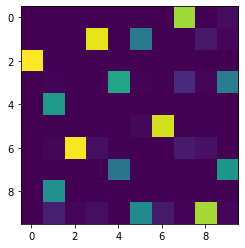

In [ ]:
def accuracy(gt, labels):
    mat = metrics.confusion_matrix(labels, gt)
    labels = mat.argmax(axis=1)[labels]
    return metrics.accuracy_score(gt, labels)


print(metrics.normalized_mutual_info_score(labels, gt), accuracy(labels, gt), accuracy(gt, labels))
plt.imshow(metrics.confusion_matrix(labels, gt))

0.7033438631743456 0.7799333333333334 0.7366166666666667


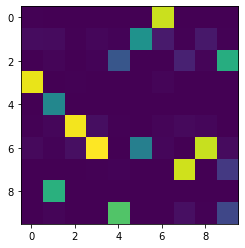

In [ ]:
def accuracy(gt, labels):
    mat = metrics.confusion_matrix(labels, gt)
    labels = mat.argmax(axis=1)[labels]
    return metrics.accuracy_score(gt, labels)


print(metrics.normalized_mutual_info_score(labels, gt), accuracy(labels, gt), accuracy(gt, labels))
plt.imshow(metrics.confusion_matrix(labels, gt))

0.7633834219211653 0.8178833333333333 0.8082


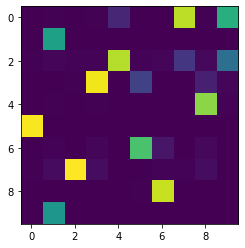

In [ ]:
def accuracy(gt, labels):
    mat = metrics.confusion_matrix(labels, gt)
    labels = mat.argmax(axis=1)[labels]
    return metrics.accuracy_score(gt, labels)


print(metrics.normalized_mutual_info_score(labels, gt), accuracy(labels, gt), accuracy(gt, labels))
plt.imshow(metrics.confusion_matrix(labels, gt))

0.5797325424089599 0.6409166666666667


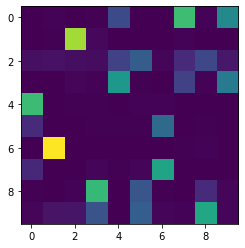

In [ ]:
def accuracy(gt, labels):
    mat = metrics.confusion_matrix(labels, gt)
    labels = mat.argmax(axis=1)[labels]
    return metrics.accuracy_score(gt, labels)


print(metrics.normalized_mutual_info_score(labels, gt), accuracy(labels, gt))
plt.imshow(metrics.confusion_matrix(labels, gt))

0.5797325424089599


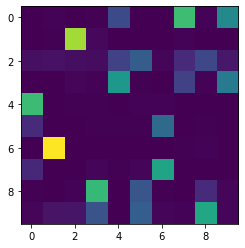

In [ ]:
print(metrics.normalized_mutual_info_score(labels, gt))
plt.imshow(metrics.confusion_matrix(labels, gt))

tensor([2.4699, 3.1566, 1.8783, 2.6202, 2.6105, 2.3367, 1.8455, 2.6642, 1.8365,
        2.1583, 2.8206, 2.1290, 1.8231, 2.1021, 3.7772, 2.0580],
       grad_fn=<SelectBackward>)

In [ ]:
z = vade_gmm.component_distribution.sample()[:,1]
z

tensor([-2.5769e+00, -2.1599e+00, -1.4897e+00,  2.4791e+00,  4.7988e-01,
        -6.3413e+00,  7.4216e-01,  2.1185e+00, -1.9867e-01,  2.3297e-03,
        -7.4168e+00,  2.6073e+00, -7.4969e-01, -9.4917e-01, -3.6461e+00,
        -4.6617e+00])

In [ ]:
def sample_vade(vade, cluster):
    z = vade_gmm.component_distribution[:,i].sample()

RuntimeError: ignored

> /usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py(458)<lambda>()
    456             Module: self
    457         """
--> 458         return self._apply(lambda t: t.cuda(device))
    459 
    460     def cpu(self: T) -> T:

ipdb> q


In [ ]:
class VariationalAutoencoder(nn.Module):
    prior = Normal(0, 1)
    def __init__(self, n_neurons=[784, 512, 256, 10], batch_norm=True, k=10):
        super(VariationalAutoencoder, self).__init__()
        n_layers = len(n_neurons) - 1
        layers = list()
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.encoder = nn.Sequential(*layers)
        self.latent_dist = LatentDistribution(n_neurons[-2], n_neurons[-1])

        layers = list()
        n_neurons = n_neurons[::-1]
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.decoder = nn.Sequential(*layers)
        # self.sigma = nn.Parameter(torch.ones(1), requires_grad=True)
        self.out_dist = LatentDistribution(n_neurons[-2], n_neurons[-1], same_sigma=True)

    def encode(self, x):
        x = self.encoder(x)
        return self.latent_dist(x).loc

    def forward(self, x):
        x = self.encoder(x)
        z_dist = self.latent_dist(x)
        z = self.latent_dist.sample()
        dist_out = self.out_dist(self.decoder(z))
        return dist_out

    def shared_step(self, batch):
        bx, by = batch
        dist_x = self.forward(bx)
        rec_loss = - dist_x.log_prob(bx).sum(dim=-1)
        kl_loss = self.latent_dist.kl_loss()
        mse_loss = F.binary_cross_entropy(torch.clamp(dist_x.loc, 1e-6, 1.0-1e-6), bx)
        loss = rec_loss + kl_loss
        return loss.mean(), rec_loss.mean(), kl_loss.mean(), mse_loss

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Lambda(lambda x: torch.flatten(x))])
                                # transforms.Lambda(lambda x: x.true_divide(255))])


class PLAutoencoder(pl.LightningModule):
    def __init__(self, n_neurons=[784, 512, 256, 10], lr=1e-3, batch_norm=True):
        super(PLAutoencoder, self).__init__()
        self.hparams = {'lr': lr}
        self.model = VariationalAutoencoder(n_neurons, batch_norm=batch_norm)

    def forward(self, x):
        return self.model(x)

    def train_dataloader(self):
        dataset = MNIST("data", download=True, transform=transform)
        return DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

    def val_dataloader(self):
        dataset = MNIST("data", download=True, transform=transform, train=False)
        return DataLoader(dataset, batch_size=256, shuffle=True, num_workers=4)

    def configure_optimizers(self):
        opt = torch.optim.Adam(self.parameters(), self.hparams['lr'])
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.2 ,patience=20, verbose=True, min_lr=1e-6)
        scheduler = {'scheduler': sched, 'interval': 'epoch', 'monitor': 'val_checkpoint_on', 'reduce_on_plateau': True}
        return opt
    
    def training_step(self, batch, batch_idx):
        loss, rec_loss, kl_loss, mse_loss = self.model.shared_step(batch)
        result = pl.TrainResult(loss)
        result.log('train_loss', loss, prog_bar=True)
        result.log("train_rec_loss", rec_loss, prog_bar=True)
        result.log('train_kl_loss', kl_loss, prog_bar=True)
        result.log('train_mse_loss' ,mse_loss, prog_bar=True)
        return result

    def validation_step(self, batch, batch_idx):
        loss, rec_loss, kl_loss, mse_loss  = self.model.shared_step(batch)
        result = pl.EvalResult(loss)
        result.log('eval_loss', loss, prog_bar=True)
        result.log("eval_rec_loss", rec_loss, prog_bar=True)
        result.log('eval_kl_loss', kl_loss, prog_bar=True)
        result.log('eval_mse_loss' ,mse_loss, prog_bar=True)
        return result

In [ ]:
%pdb on
model = PLAutoencoder(n_neurons=[784, 1024, 1024, 512, 10], lr=1e-3)
logger = pl.loggers.WandbLogger(project='prob_VAE_MNIST1')
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=100, logger=logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
wandb: Waiting for W&B process to finish, PID 837
wandb: Program ended successfully.


Automatic pdb calling has been turned ON



wandb:                                                                                
wandb: Find user logs for this run at: wandb/run-20200923_082136-1e8uso23/logs/debug.log
wandb: Find internal logs for this run at: wandb/run-20200923_082136-1e8uso23/logs/debug-internal.log
wandb: Run summary:
wandb:      global_step 23499
wandb:       train_loss -624.4754028320312
wandb:   train_rec_loss -658.692138671875
wandb:    train_kl_loss 34.21669006347656
wandb:   train_mse_loss 0.1052691787481308
wandb:            epoch 99
wandb:            _step 499
wandb:         _runtime 1241
wandb:       _timestamp 1600850538
wandb:        eval_loss -609.533935546875
wandb:    eval_rec_loss -643.8043212890625
wandb:     eval_kl_loss 34.27037811279297
wandb:    eval_mse_loss 0.10617610067129135
wandb: Run history:
wandb:      global_step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:       train_loss █▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:   train_rec_loss █▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


  | Name  | Type                   | Params
-------------------------------------------------
0 | model | VariationalAutoencoder | 4 M   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

In [ ]:
%pdb on
model = PLAutoencoder(n_neurons=[784, 1024, 1024, 512, 10], lr=1e-3)
logger = pl.loggers.WandbLogger(project='prob_VAE_MNIST1')
trainer = pl.Trainer(gpus=1, progress_bar_refresh_rate=10, max_epochs=100, logger=logger)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Automatic pdb calling has been turned ON


wandb: Currently logged in as: shukistern (use `wandb login --relogin` to force relogin)
wandb: Tracking run with wandb version 0.10.2
wandb: Run data is saved locally in wandb/run-20200923_082136-1e8uso23
wandb: Syncing run skilled-wood-30



  | Name  | Type                   | Params
-------------------------------------------------
0 | model | VariationalAutoencoder | 4 M   


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for validation and test dataloaders.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: The metric you returned None must be a `torch.Tensor` instance, checkpoint not saved HINT: what is the value of loss in validation_epoch_end()?
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:37: RuntimeWarning: Can save best model only with loss available, skipping.
  warnings.warn(*args, **kwargs)


Saving latest checkpoint..


1

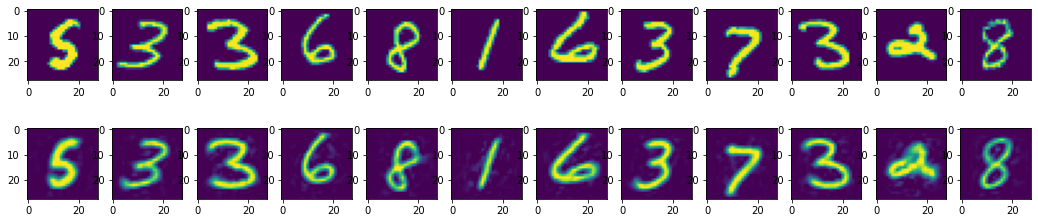

In [ ]:
bx, by = next(iter(model.val_dataloader()))
with torch.no_grad():
    orig = bx.reshape(-1, 28, 28).numpy()
    out_dist = model(bx)
    out = model.model(bx).loc.reshape(-1, 28, 28).numpy().clip(0., 1.)

ncols = 12
fig, axes = plt.subplots(nrows=2, ncols=ncols, figsize=(18, 4))
for i in range(ncols):
    axes[0][i].imshow(orig[i])
    axes[1][i].imshow(out[i])

Parameter containing:
tensor([0.1056], requires_grad=True)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix, accuracy_score

def create_encoded_data(dl, model):
    X, y = [], []
    model.cuda()
    with torch.no_grad():
        for bx, by in dl:
            X.append(model.encode(bx.cuda()).cpu().numpy())
            y.append(by.numpy())
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)      
    return X, y

X, y = create_encoded_data(model.train_dataloader(), model.model)

0.7410597251365298


0.8122333333333334

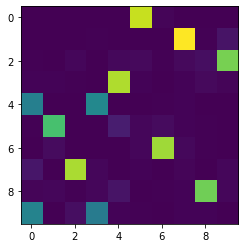

In [ ]:
kmeans = KMeans(n_clusters=10)
labels = kmeans.fit_predict(X)

print(normalized_mutual_info_score(y, labels))

mat = confusion_matrix(y, labels)
plt.imshow(mat)

mat.argmax(axis=1)
def accuracy(y, labels):
    mat = confusion_matrix(y, labels)
    labels = mat.argmax(axis=0)[labels]
    return accuracy_score(y, labels)

accuracy(y, labels)


In [ ]:
class VariationalAutoencoder(nn.Module):
    prior = Normal(0, 1)
    def __init__(self, n_neurons=[784, 512, 256, 10], batch_norm=True, k=10):
        super(VariationalAutoencoder, self).__init__()
        n_layers = len(n_neurons) - 1
        layers = list()
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.encoder = nn.Sequential(*layers)
        self.latent_mu = nn.Linear(n_neurons[-2], n_neurons[-1])
        self.latent_sigma = nn.Sequential(nn.Linear(n_neurons[-2], n_neurons[-1]), 
                                          nn.Softplus(beta=1))
        layers = list()
        n_neurons = n_neurons[::-1]
        for i in range(n_layers-1):
            layers.append(nn.Linear(n_neurons[i], n_neurons[i+1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(n_neurons[i+1]))
            layers.append(nn.ELU())
        self.decoder = nn.Sequential(*layers)

        self.out_mu = nn.Linear(n_neurons[-2], n_neurons[-1])
        self.sigma = nn.Parameter(torch.ones(1), requires_grad=True)
        self.out_sigma = nn.Sequential(nn.Linear(n_neurons[-2], n_neurons[-1]), 
                                       nn.Softplus(beta=0.2))
        
    def encode(self, x):
        x = self.encoder(x)
        return self.latent_mu(x)

    def forward(self, x):
        x = self.encoder(x)
        dist_z = Normal(self.latent_mu(x), self.latent_sigma(x))
        z = dist_z.rsample()
        out = self.decoder(z)
        dist_x = Normal(self.out_mu(out), self.sigma)
        return dist_x, dist_z

    def shared_step(self, batch):
        bx, by = batch
        dist_x, dist_z = self.forward(bx)
        rec_loss = - dist_x.log_prob(bx).sum(dim=-1)
        kl_loss = kl_divergence(dist_z, self.prior).sum(dim=-1)
        mse_loss = F.binary_cross_entropy(torch.clamp(dist_x.loc, 1e-6, 1.0-1e-6), bx)
        # import pdb; pdb.set_trace()
        loss = rec_loss + kl_loss
        return loss.mean(), rec_loss.mean(), kl_loss.mean(), mse_loss